<a href="https://colab.research.google.com/github/minhiungan2608/Project-Machine-Failure-Prediction-using-NLP-BERT/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 20: Anomaly Detection in Sensor Data using NLP Techniques

Description: Apply NLP techniques to analyze time-series sensor data for anomaly detection. Convert sensor data into sequences and use models like BERT to identify abnormal patterns, which can be useful in industrial IoT scenarios.

**BERT = Bidirectional Encoder Representations from Transformers**
* A pre-trained language model
* Developed by Google AI in 2018
* Revolutionized NLP (Natural Language Processing)

**BERT is a powerful AI model originally designed for NLP, but can be adapted for Time Series thanks to:**
* Self-Attention: Learns dependencies between timesteps
* Bidirectional: Views both past and future
* Transfer Learning: Pre-trained on large data
* Contextualized: Understands complex patterns

**In this project, BERT is used to predict machine failure based on sensor readings over time.**

In [3]:
!pip install transformers datasets evaluate accelerate
!pip install seaborn matplotlib scikit-learn
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [4]:
import os
os.environ["WANDB_PROJECT"] = "Machine_Failure_Prediction"
os.environ["WANDB_NAME"] = "BERT_Quantization_Run"
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "false"

In [5]:
!pip install --upgrade wandb
import wandb

wandb.init(
    project="Machine_Failure_Prediction",
    name="BERT_Quantization_Run",
    reinit=False,
    settings=wandb.Settings(start_method="thread")
)

wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hoangkhaiminhk23 (hoangkhaiminhk23-tokyo-international-uni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
# Load dataset into DataFrame
df = pd.read_csv('/content/drive/My Drive/Machine Failure /machine failure.csv')

# Show first rows
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [8]:
print("'Machine failure':")
print(df['Machine failure'].value_counts())

'Machine failure':
Machine failure
0    9661
1     339
Name: count, dtype: int64


In [9]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns

RND = 42
np.random.seed(RND)
random.seed(RND)
torch.manual_seed(RND)

print("Torch device:", torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Torch device: False CPU


In [10]:
# SIMPLE EDA
print("Columns:", df.columns.tolist()) #ls all columns in DataFrame
print("\nInfo:") #information
print(df.info())

print("\nDescribe:")
display(df.describe())

# If 'Machine failure' or 'machine_failure' in dataset, find the exact name:
possible_label_names = [c for c in df.columns if 'fail' in c.lower() or 'failure' in c.lower()]
print("\nDetected label-like columns:", possible_label_names)

Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      1000

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000



Detected label-like columns: ['Machine failure']


#EXPLORATORY DATA ANALYSIS (EDA)

## 1. Dataset Overview

The **Machine Failure Prediction** dataset contains information about machine operations in manufacturing with the goal of predicting failure occurrences.

### Basic Information:
- **Number of rows**: 10,000 entries (observations)
- **Number of columns**: 14 columns (attributes)
- **Missing data**: No missing values (all columns have 10000 non-null)
- **Memory usage**: 1.1+ MB
- **Data types**:
  - float64: 3 columns (temperatures, torque)
  - int64: 9 columns (IDs, speed, wear, failure types)
  - object: 2 columns (Product ID, Type)

---

## 2. Attributes Description

###Input Features:

| Attribute | Meaning | Unit | Description |
|-----------|---------|------|-------------|
| **UDI** | Unique Data Identifier | - | Sequential number from 1-10000 |
| **Product ID** | Product Identifier | - | Product identification code (M14860, L47181...) |
| **Type** | Product Type | M/L/H | M=Medium, L=Low, H=High quality |
| **Air temperature [K]** | Air Temperature | Kelvin | Ambient temperature around machine |
| **Process temperature [K]** | Process Temperature | Kelvin | Temperature during operation |
| **Rotational speed [rpm]** | Rotational Speed | rpm | Revolutions per minute |
| **Torque [Nm]** | Torque | Newton-meter | Rotational force of machine |
| **Tool wear [min]** | Tool Wear | minutes | Tool usage time |

###Target Variables:

| Variable | Full Name | Description |
|----------|-----------|-------------|
| **Machine failure** | Machine Failure | Main target variable (0=OK, 1=Failure) |
| **TWF** | Tool Wear Failure | Failure due to worn tool |
| **HDF** | Heat Dissipation Failure | Failure due to poor heat dissipation |
| **PWF** | Power Failure | Failure due to power issues |
| **OSF** | Overstrain Failure | Failure due to overload |
| **RNF** | Random Failures | Random/unexplained failures |

---

## 3. Statistical Analysis

###Air Temperature [K]
- **Mean**: 300.00 K (~27°C)
- **Standard Deviation**: 2.00 K → Very low variability
- **Range**: 295.3 - 304.5 K
- **Insight**: Ambient temperature is very stable, indicating controlled environment

###Process Temperature [K]
- **Mean**: 310.01 K (~37°C)
- **Standard Deviation**: 1.48 K → Extremely low variability
- **Range**: 305.7 - 313.8 K
- **Insight**: Operating temperature is ~10°C higher than ambient, very consistent

###Rotational Speed [rpm]
- **Mean**: 1538.78 rpm
- **Standard Deviation**: 179.28 → Moderate to high variability
- **Range**: 1168 - 2886 rpm
- **Median (50%)**: 1503 rpm
- **Insight**: Wide range of operational speeds, some machines run at very high speeds (2886 rpm)

###Torque [Nm]
- **Mean**: 39.99 Nm
- **Standard Deviation**: 9.97 → Moderate variability
- **Range**: 3.8 - 76.6 Nm
- **Quartiles**: Q1=33.2, Median=40.1, Q3=46.8
- **Insight**: Torque varies significantly across operations, indicating diverse workload ⚙️

###Tool Wear [min]
- **Mean**: 107.95 minutes
- **Standard Deviation**: 63.65 → High variability
- **Range**: 0 - 253 minutes
- **Median (50%)**: 108 minutes
- **Quartiles**: Q1=53, Q3=162
- **Insight**: Wide distribution from brand new (0 min) to heavily worn tools (253 min)

---

## 4. Target Variable Analysis

###Machine Failure (Main Target)
- **Failure Rate**: 3.39% (339 out of 10,000 cases)
- **Class Distribution**:
  - No Failure (0): 96.61% (9,661 cases)
  - Failure (1): 3.39% (339 cases)
- **Critical Issue**: **Highly imbalanced dataset** - this will require special handling during model training

###Failure Type Breakdown:

| Failure Type | Percentage | Approximate Count | Description |
|--------------|-----------|-------------------|-------------|
| **TWF** | 0.46% | ~46 cases | Tool Wear Failure |
| **HDF** | 1.15% | ~115 cases | Heat Dissipation Failure |
| **PWF** | 0.95% | ~95 cases | Power Failure |
| **OSF** | 0.98% | ~98 cases | Overstrain Failure |
| **RNF** | 0.19% | ~19 cases | Random Failures |

###Observations:
- **Heat Dissipation Failure (HDF)** is the most common failure type (1.15%)
- **Random Failures (RNF)** are the rarest (0.19%)
- **Total failure instances**: Some machines may have multiple failure types simultaneously
- All failure types are rare events (< 2% each)

---

## 5. Key Insights & Data Quality

###Strengths:
1. **Complete dataset**: No missing values across all 10,000 observations
2. **Clean data**: All columns have consistent data types
3. **Sufficient sample size**: 10,000 samples provide good statistical power
4. **Well-documented**: Clear column names and units

###Challenges:

#### 1. **Class Imbalance**
- Only 3.39% positive cases (failures)
- **Impact**: Model may be biased toward predicting "no failure"

#### 2. **Variable Scaling**
- Features have different scales:
  - Temperature: ~300 K
  - Rotational speed: ~1500 rpm
  - Torque: ~40 Nm
  - Tool wear: ~100 min
- **Impact**: May affect model convergence
- **Solution**: Standardization or normalization required

#### 3. **Feature Variability**
- High variance in:
  - Rotational speed (std=179.28)
  - Tool wear (std=63.65)
- Low variance in:
  - Temperatures (std=1.48-2.00)
- **Consideration**: High-variance features may dominate model training

In [11]:
# NORMALIZE COLUMN NAMES AND IDENTIFY SENSOR + LABEL COLUMNS
# Check and map names:
expected_sensors = ['Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] #ls expected sensors/ input features in the dataset

# ls all columns in df and print to check
cols = df.columns.tolist()
print("All columns:", cols)

COLUMN_MAPPING = {} # empty DICT to map old col --> new col

# Apply mapping if provided
if COLUMN_MAPPING:
    df = df.rename(columns=COLUMN_MAPPING)

# Find sensor columns that exist
sensor_cols = [c for c in expected_sensors if c in df.columns]
if len(sensor_cols) < len(expected_sensors):
    print("Not all default sensor columns found.")
    print("Detected sensors:", sensor_cols)
else:
    print("Detected sensor columns:", sensor_cols)

# Detect label column automatically:
label_col = None
for c in df.columns:
    if c.lower() in ['machine failure', 'machine_failure', 'machinefailure', 'failure', 'machine failure (1=fail)']:
        label_col = c
        break

# If not available, try to find any column with 0/1
if label_col is None:
    for c in df.columns:
        if set(df[c].dropna().unique()).issubset({0,1}):
            label_col = c
            break

print("Using label column:", label_col)

All columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Detected sensor columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Using label column: Machine failure


Benefits:
* Automation: No need to hardcode column names
* Flexibility: Works with different column name formats
* Early error detection: Warns if important columns are missing
* Code reusability: This code can run on many similar datasets

Prepare to split X (features) and y (target) for model training

In [12]:
from sklearn.preprocessing import StandardScaler

# Check missing values
print("Missing per column:\n", df.isna().sum()) # No missing values, but keep for reusability

# Handle missing values
if df.isna().sum().sum() > 0:
    df = df.ffill().bfill()
    print("Missing values filled")
else:
    print("No missing values detected")

# Scale sensors
scaler = StandardScaler() # z = (x - mean) / std
df[sensor_cols] = scaler.fit_transform(df[sensor_cols]) # mean = 0; std= 1

print("After scaling (head):")
display(df[sensor_cols].head()) # print scaled result

Missing per column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64
No missing values detected
After scaling (head):


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588


* Missing values: 0
* Sensor columns: Already normalized (mean=0, std=1)
* Data is ready for BERT

In [13]:
# SLIDING WINDOW → create sequences (X) and labels (y)
import numpy as np

WINDOW_SIZE = 20   # Number of timesteps per window
STRIDE = 1
# --> STRIDE = 1:
# Window 1: rows [0-19]
# Window 2: rows [1-20]
# Window 3: rows [2-21]
values = df[sensor_cols].values # values: Numpy array containing sensor columns (already scaled)
labels = df[label_col].astype(int).values # labels: Numpy array containing labels (Machine failure)

def create_windows(values, labels, window_size=WINDOW_SIZE, stride=STRIDE):
    Xw, yw = [], []
    # Xw: List with windows (features)
    # yw: List with lables
    L = len(values) # L = all rows in dataset
    for i in range(0, L - window_size + 1, stride):
        w = values[i:i+window_size]            # shape (window_size, n_sensors)
        lab = int(labels[i:i+window_size].max())  # if any failure in window -> label=1
      # Add into lists
        Xw.append(w)
        yw.append(lab)
    return np.array(Xw), np.array(yw) # convert ls into numpy arrays

X_w, y_w = create_windows(values, labels)
print("Created windows:", X_w.shape, y_w.shape)
print("Label distribution in windows:", np.bincount(y_w))

Created windows: (9981, 20, 5) (9981,)
Label distribution in windows: [5974 4007]


**Purpose: Sliding Window**

Sliding Window is a technique that transforms time series data into sequences for model training.

Original data: [d1, d2, d3, d4, d5, d6, d7, d8, ...]

Window size = 3:
* Window 1: [d1, d2, d3] → label: d4
* Window 2: [d2, d3, d4] → label: d5
* Window 3: [d3, d4, d5] → label: d6

...

**The model can see:**
* Temperature increasing/decreasing trends
* How rotational speed changes
* Tool wear progression
* Temporal dependencies → BERT can learn the patterns



BERT is designed for discrete tokens → Time-series like features in dataset → BERT aint understand → Quantization: Change continuous values → discrete tokens

* Temperature 298.1 K  → Token ID: 15
* Temperature 300.5 K  → Token ID: 42
* Speed 1551 rpm       → Token ID: 59

In [14]:
# K-MEANS QUANTIZATION
from sklearn.cluster import KMeans

NUM_TOKENS = 64   # Vocab size (optimal: 32-256)
n_sensors = X_w.shape[-1]
print("n_sensors:", n_sensors)

# Fit k-means on all timestep vectors
all_vectors = X_w.reshape(-1, n_sensors)   # shape (n_windows * window_size, n_sensors)
print("Fitting KMeans on", all_vectors.shape, "vectors ...")
kmeans = KMeans(n_clusters=NUM_TOKENS, random_state=RND, n_init=10).fit(all_vectors)

# Convert each timestep vector to a token id
def window_to_tokens(window):
    # window shape: (window_size, n_sensors)
    return [int(lbl) for lbl in kmeans.predict(window)]

tokenized = [window_to_tokens(w) for w in X_w]
print("Example token sequence (1 window):", tokenized[0][:20], "... length:", len(tokenized[0]))

n_sensors: 5
Fitting KMeans on (199620, 5) vectors ...
Example token sequence (1 window): [9, 59, 59, 9, 59, 59, 9, 9, 50, 24, 24, 11, 20, 24, 7, 29, 11, 11, 20, 38] ... length: 20


In [15]:
# Prepare input_ids (padded) and attention_mask
import torch
from datasets import Dataset, DatasetDict

MAX_LEN = WINDOW_SIZE

input_ids = [seq[:MAX_LEN] + [NUM_TOKENS]*max(0, MAX_LEN - len(seq)) for seq in tokenized]  # Pad with NUM_TOKENS
attention_mask = [[1]*min(len(seq), MAX_LEN) + [0]*max(0, MAX_LEN - len(seq)) for seq in tokenized] # attention mask purpose: let BERT separate real token and padding token

# Confirm pad id (NUM_TOKENS) is currently the pad token
pad_token_id = NUM_TOKENS # let BERT know padding when train

# Create HuggingFace dataset from dictionary
ds = Dataset.from_dict({
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": y_w.tolist()
})

# Split train/test (random seed for reproducibility)
ds = ds.train_test_split(test_size=0.2, seed=RND) # 20% test/ 80% train
print(ds)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7984
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1997
    })
})


# Case 1: Sequence long enough
seq = [9, 59, 59, 59, 9, 59, 59, 9, 9, 50, 24, 24, 11, 20, 24, 7, 29, 11, 11, 20]

len(seq) = 20

MAX_LEN - len(seq) = 20 - 20 = 0

[NUM_TOKENS] * 0 = []

result = [9, 59, 59, ..., 20] + [] = [9, 59, 59, ..., 20]  # Unchanged

# Case 2: In case of shorter ones

seq = [9, 59, 59, 11, 20]

len(seq) = 5

MAX_LEN - len(seq) = 20 - 5 = 15

[NUM_TOKENS] * 15 = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]

result = [9, 59, 59, 11, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
   
      ↑───────real tokens─────↑  ↑─────────────padding (15 tokens)─────────────↑

# Case 1: Full-length sequence (20 tokens)

seq = [9, 59, 59, ..., 20]  # Length = 20

min(len(seq), MAX_LEN) = min(20, 20) = 20

max(0, MAX_LEN - len(seq)) = max(0, 0) = 0

attention_mask = [1]*20 + [0]*0 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

                                   ↑─────────────All tokens are attended─────────────────↑

# Case 2: Short sequence (5 tokens, padded to 20)

seq = [9, 59, 59, 11, 20]  # Length = 5

min(len(seq), MAX_LEN) = min(5, 20) = 5

max(0, MAX_LEN - len(seq)) = max(0, 15) = 15

attention_mask = [1]*5 + [0]*15 = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

                                     ↑──real──↑  ↑──────────ignore padding──────────↑

In [16]:
# Dictionary Structure
# 3 components:
# input_ids: Tokenized sequences (padded)
# attention_mask: Which tokens to attend
# labels: Target values (failure or not)
{
    "input_ids": [
        [9, 59, 59, ..., 20],      # Sequence 0
        [19, 59, 59, ..., 38],     # Sequence 1
        ...
    ],
    "attention_mask": [
        [1, 1, 1, ..., 1],         # Mask for sequence 0
        [1, 1, 1, ..., 1],         # Mask for sequence 1
        ...
    ],
    "labels": [0, 0, 1, 0, ...]    # Labels (0 or 1)
}

{'input_ids': [[9, 59, 59, Ellipsis, 20],
  [19, 59, 59, Ellipsis, 38],
  Ellipsis],
 'attention_mask': [[1, 1, 1, Ellipsis, 1], [1, 1, 1, Ellipsis, 1], Ellipsis],
 'labels': [0, 0, 1, 0, Ellipsis]}

In [17]:
# CALCULATE CLASS WEIGHTS
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Get labels from the training set
train_labels = ds["train"]["labels"]

# Calculate class weights
# 'balanced' automatically calculates weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert weights to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights_tensor)

Class weights: tensor([0.8308, 1.2557])


**Class 0 weight = 0.8308 (< 1.0):**

* Lighter penalty when wrong

* Because this class already has many samples

**Class 1 weight = 1.2557 (> 1.0):**

* Heavier penalty ~51% compared to class 0

* Ratio: 1.2557 / 0.8308 ≈ 1.51

* Compensates for having fewer sample

In [18]:
# BUILD BERT CONFIG & MODEL
from transformers import BertConfig, BertForSequenceClassification

vocab_size = NUM_TOKENS + 1  # +1 for PAD token id
config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=512,
    max_position_embeddings=512,
    pad_token_id=pad_token_id,
    num_labels=2
)

model = BertForSequenceClassification(config)
print(model.config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 64,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 65
}



In [19]:
import torch
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np
from torch import nn

# Metrics
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"]
    }

# Define a custom Trainer subclass to override the compute_loss method
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Use class_weights_tensor in CrossEntropyLoss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="bert_failure_out",
    learning_rate=3e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,

    # REMOVE problematic arguments
    logging_steps=50,
    save_steps=500,
    # no eval strategy → no load_best_model_at_end
    load_best_model_at_end=False
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=None,
    compute_metrics=compute_metrics
)

print("Trainer is ready.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/tmp/ipython-input-706461378.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Trainer is ready.


In [20]:
# TRAIN
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.632800
100,0.597400
150,0.579600
200,0.568700
250,0.544500
300,0.527500
350,0.509300
400,0.519800
450,0.487400
500,0.494300


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1000, training_loss=0.5056363277435303, metrics={'train_runtime': 325.7268, 'train_samples_per_second': 196.091, 'train_steps_per_second': 3.07, 'total_flos': 6209232168960.0, 'train_loss': 0.5056363277435303, 'epoch': 8.0})

In [21]:
# EVALUATE
eval_res = trainer.evaluate()
print("Eval results:", eval_res)

# Predict on test to get confusion matrix, probs
pred_out = trainer.predict(ds["test"])
logits = pred_out.predictions
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:,1]
preds = np.argmax(logits, axis=-1)
labels = pred_out.label_ids

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Eval results: {'eval_loss': 0.4676198959350586, 'eval_accuracy': 0.771657486229344, 'eval_f1': 0.7379310344827587, 'eval_runtime': 2.9687, 'eval_samples_per_second': 672.694, 'eval_steps_per_second': 5.39, 'epoch': 8.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix:
 [[899 270]
 [186 642]]


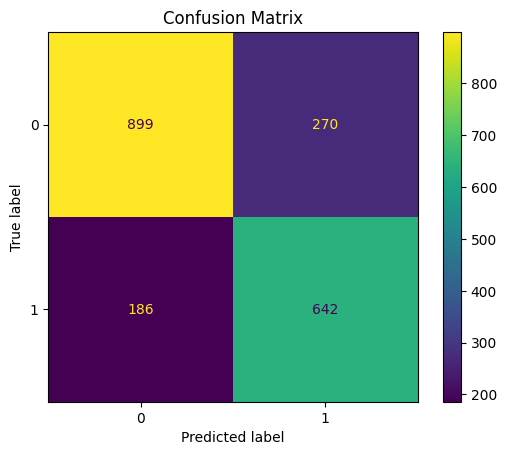


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1169
           1       0.70      0.78      0.74       828

    accuracy                           0.77      1997
   macro avg       0.77      0.77      0.77      1997
weighted avg       0.78      0.77      0.77      1997



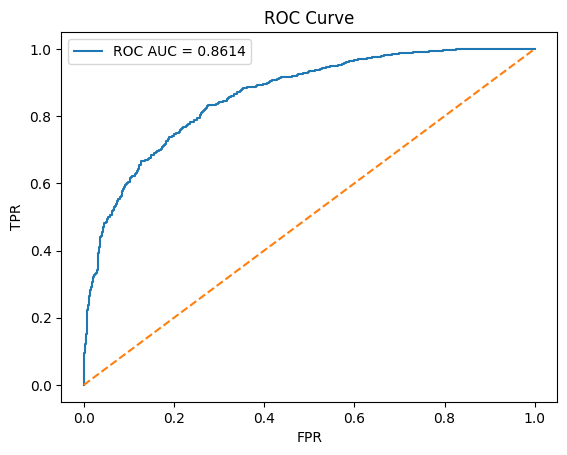

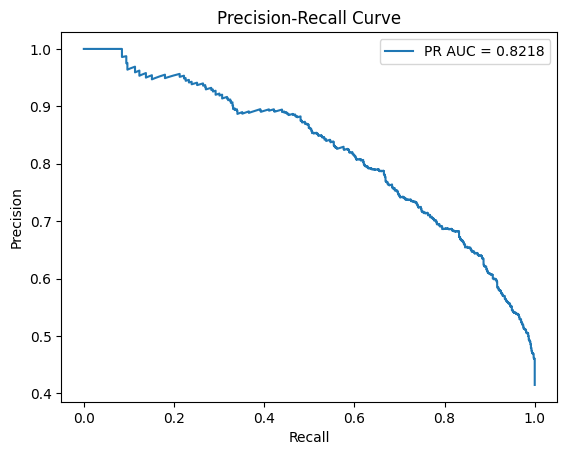

In [22]:
# VISUALIZATION: Confusion Matrix + ROC + PR Curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(labels, preds))

# ROC AUC
roc_auc = roc_auc_score(labels, probs)
fpr, tpr, _ = roc_curve(labels, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()

# PR curve
precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()

Model Evaluation Summary

 • The confusion matrix shows balanced performance, with class 1 recall at 0.78, meaning the model correctly captures most positive cases.

 • Precision for class 1 is 0.70, so the model still produces some false positives.

 • Overall accuracy is 0.77, indicating moderate performance.

 • ROC AUC = 0.86 and PR AUC = 0.82, which are strong scores and show the model separates the two classes well.

Conclusion

The model performs fairly well and can distinguish classes effectively, but precision for the positive class can be improved. Tuning the threshold or using a stronger model (e.g., XGBoost/LightGBM) could increase performance

In [23]:
# SAVE MODEL & ARTIFACTS
import os
out_dir = "exported_model"
os.makedirs(out_dir, exist_ok=True)

# Save model weights + config
model.save_pretrained(out_dir)

# Save KMeans centroids (codebook) for inference later
import joblib
joblib.dump(kmeans, os.path.join(out_dir, "kmeans_codebook.joblib"))

# Save sensor scaler so that inference can apply same scaling
joblib.dump(scaler, os.path.join(out_dir, "sensor_scaler.joblib"))

# Zip everything
!zip -r exported_model.zip {out_dir}
print("Saved model and artifacts to", out_dir, "and zipped.")

  adding: exported_model/ (stored 0%)
  adding: exported_model/model.safetensors (deflated 7%)
  adding: exported_model/kmeans_codebook.joblib (deflated 97%)
  adding: exported_model/config.json (deflated 48%)
  adding: exported_model/sensor_scaler.joblib (deflated 35%)
Saved model and artifacts to exported_model and zipped.


In [24]:
# INFERENCE FUNCTION FOR A NEW SENSOR SEQUENCE
import numpy as np
import joblib
from transformers import BertForSequenceClassification

# Load artifacts
kmeans = joblib.load("exported_model/kmeans_codebook.joblib")
scaler = joblib.load("exported_model/sensor_scaler.joblib")
model = BertForSequenceClassification.from_pretrained("exported_model")
model.eval()
if torch.cuda.is_available():
    model.to("cuda")

def predict_window(sensor_window):
    """
    sensor_window: numpy array shape (window_size, n_sensors)
    returns: probability of failure in that window
    """
    # Scale input
    sensor_window = scaler.transform(sensor_window)
    # Quantize to tokens
    tokens = [int(t) for t in kmeans.predict(sensor_window)]
    # Pad if needed
    if len(tokens) < MAX_LEN:
        tokens = tokens + [pad_token_id] * (MAX_LEN - len(tokens))
    input_ids = torch.tensor([tokens], dtype=torch.long)
    attention_mask = torch.tensor([[1]*len(tokens)], dtype=torch.long)
    if torch.cuda.is_available():
        input_ids = input_ids.to("cuda"); attention_mask = attention_mask.to("cuda")
    with torch.no_grad():
        out = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0,1]
    return float(probs)

# Example: take the first window
example_window = X_w[0]
print("Example window failure prob:", predict_window(example_window))

Example window failure prob: 0.9154743552207947


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
